# Project 02 - Image segmentation and object detection

In this project, we would like you to investigate image segmentation and object detection.
For this, you will use the data from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC039).
The dataset contains images of cells acquired using fluorescence microscopy, along with annotations of individual cells.
Your goal will be to apply the segmentation and detection methods described in the lecture to the dataset.

__Note:__ The main goal of this project to get you working on a real-world segmentation/detection task. Projects will not be graded based on the performance of the trained classifiers.

![A stack of images](./broad_dataset.png)

We suggest that you follow the following  steps:
1. __Know your data__ Have a look  at the resources provided on the website to understand the dataset.
1. Download and inspect the images, groundtruth annotations, and metadata. Plot a few example datapoints. __Tip:__ The data has fixed URLs, so you can download the data from within the notebook (e.g., using `!wget URL`).
1. Write a data loader that allows you to use the data in PyTorch. Split the data according to the training, test, and validation files provided in the metadata.
1. Train one or multiple of the segmentation models discussed in the lecture (or any other segmentation model you would like to try) to segment the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s). 
1. Train one of multiple of the detection models discussed in the lecture (or any other detection method you would like to try) to detect the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s). 

Tipps and hints:
1. Please do not add the dataset to your submission. Use `.gitignore` to ignore the directory containing the downloaded dataset.
1. Think about how you have to process the provided groundtruth data to make it usable for segmentation and detection.
1. `scikit-image` provides several helpful functions for extracting information from masks. Have a look at `skimage.measure.label` and `skimage.measure.regionprops`. These can help to convert data into a format that is appropriate for detection.

In [1]:
# imports
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import skimage

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

from unet import UNet, Encoder

### Looking at the data

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, partition="Training"):
        # load the data
        assert partition in ["training", "validation", "test"], f"Unknown partition: {partition}" 
        index = open(f"data/metadata/{partition}.txt").readlines()
        index = [name.split(".")[0] for name in index]
        image_files = [os.path.join("data/images", f"{name}.tif") for name in index]
        mask_files = [os.path.join("data/masks", f"{name}.png") for name in index]
        self.images = np.asarray([imread(image_file) for image_file in image_files])
        self.masks = np.asarray([imread(mask_file)[:, :, 0] > 0 for mask_file in mask_files])
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx, tensor=True):
        if tensor:
            return (torch.as_tensor((self.images[idx] / 4095).astype("float32")).unsqueeze(0), 
                   torch.as_tensor(self.masks[idx].astype("int64")).unsqueeze(0))
        else:
            return self.images[idx] / 4095, self.masks[idx]

In [3]:
train_data = Dataset("training")
validation_data = Dataset("validation")
test_data = Dataset("test")

In [ ]:
for image, mask in train_data:
    fig, axes = plt.subplots(1, 2, sharey=True, dpi=250)
    axes[0].imshow(image[0])
    axes[1].imshow(mask[0], cmap="gray")
    plt.show()

## Metrics

In [5]:
def mask_iou(mask_output, mask_target):
    return (mask_output & mask_target).sum() / (mask_output | mask_target).sum()


def mask_precision(mask_output, mask_target):
    return (mask_output & mask_target).sum() / (mask_output).sum()


def mask_recall(mask_output, mask_target):
    return (mask_output & mask_target).sum() / (mask_target).sum()


def mask_f1(mask_output, mask_target):
    precision = mask_precision(mask_output, mask_target)
    recall = mask_recall(mask_output, mask_target)
    
    return 2 * recall * precision / (recall + precision)

# Classical approach: Watershed

![Watershed Intution 01](supplementary/watershed_01.png)
![Watershed Intution 02](supplementary/watershed_02.png)

In [6]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed as sk_watershed
from skimage.feature import peak_local_max

def watershed(image):
    # detect local maxima in the original image, which correspond to local minima in the flipped image
    markers = peak_local_max(image, threshold_abs=0.08, min_distance=20, footprint=np.ones((10, 10)))
    
    # convert to watershed format
    mask = np.zeros(image.shape, dtype=bool)
    mask[tuple(markers.T)] = True
    markers, _ = ndi.label(mask)
    
    # run the watershed
    return sk_watershed(-image, markers=markers, mask=image > 0.08)

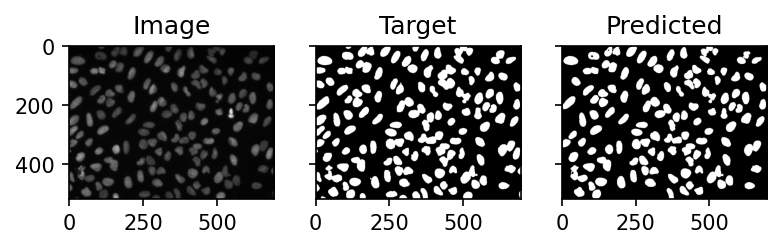

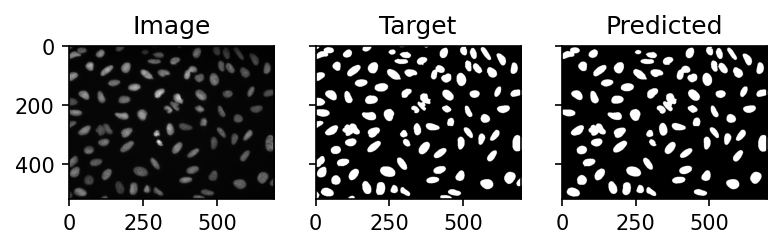

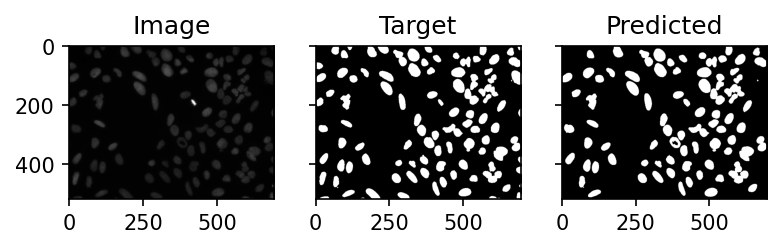

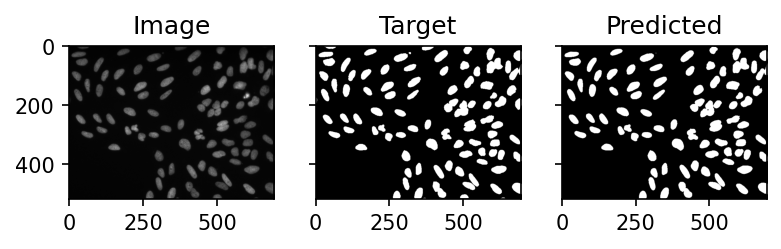

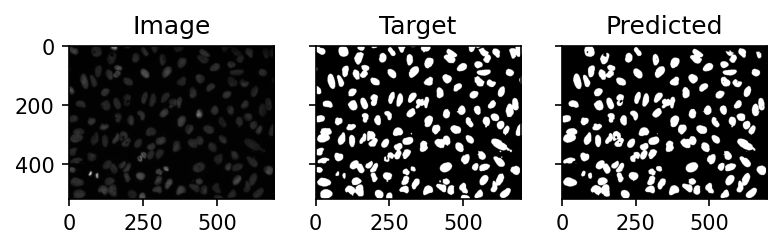

In [7]:
n = 50
watershed_ious = np.empty(n, dtype="float32")
watershed_f1 = np.empty(n, dtype="float32")
for idx in range(n):
    image, mask = test_data.__getitem__(idx, tensor=False)
    labels = watershed(image)
    
    if idx % 10 == 0:
        fig, axes = plt.subplots(1, 3, sharey=True, dpi=150)
        axes[0].imshow(image, cmap="gray")
        axes[0].set_title("Image")
        axes[1].imshow(mask, cmap="gray")
        axes[1].set_title("Target")
        axes[2].imshow(labels > 0, cmap="gray")
        axes[2].set_title("Predicted")
        plt.show()
    
    watershed_ious[idx] = mask_iou(labels > 0, mask)
    watershed_f1[idx] = mask_f1(labels > 0, mask)

# Segmentation with U-Net

![picture of a unet](supplementary/unet.png)

In [8]:
def train_one_epoch(train_loader, model, optimizer, loss_fn):
    losses = []
    model.train()
 
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        image = data[0].to("cuda:0")
        mask = data[1].to("cuda:0")

        # train the model
        output = model(image)
        loss = loss_fn(output, mask.squeeze())
        with torch.set_grad_enabled(True):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        losses.append(loss.item())

        tk0.set_postfix(loss=sum(losses) / len(losses), learning_rate=optimizer.param_groups[0]['lr'])
        del image, mask, output
        
    return np.asarray(losses)

def validate(valid_loader, model, loss_fn):
    losses = []
    model.eval()
    
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        image = data[0].to("cuda:0")
        mask = data[1].to("cuda:0")

        # train the model
        with torch.no_grad():
            output = model(image)
            loss = loss_fn(output, mask.squeeze())
            losses.append(loss.item())

        tk0.set_postfix(loss=sum(losses) / len(losses), learning_rate=optimizer.param_groups[0]['lr'])
        del image, mask, output
        
    return np.asarray(losses)

In [9]:
batch_size = 16
lr = 0.001
weight_decay = 0.001
epochs = 10

# define the model
unet_model = UNet(enc_chs=[1, 16, 32], dec_chs=[32, 16], num_class=2)
unet_model.to("cuda:0")


# train the model
loss_fn = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=batch_size, pin_memory=True, shuffle=True)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr, weight_decay=weight_decay)

losses = None
losses_valid = None
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} - Training")
    loss = train_one_epoch(train_loader, unet_model, optimizer, loss_fn)
    losses = loss if losses is None else np.concatenate((losses, loss))
    
    # validation
    print(f"Epoch: {epoch+1} - Validation")
    loss_valid = validate(valid_loader, unet_model, loss_fn)
    losses_valid = loss_valid if losses_valid is None else np.concatenate((losses_valid, loss_valid))

Epoch: 1 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.82it/s, learning_rate=0.001, loss=0.576]


Epoch: 1 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.52it/s, learning_rate=0.001, loss=0.699]


Epoch: 2 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.73it/s, learning_rate=0.001, loss=0.432]


Epoch: 2 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.88it/s, learning_rate=0.001, loss=0.706]


Epoch: 3 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.68it/s, learning_rate=0.001, loss=0.358]


Epoch: 3 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.49it/s, learning_rate=0.001, loss=0.652]


Epoch: 4 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.62it/s, learning_rate=0.001, loss=0.334]


Epoch: 4 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s, learning_rate=0.001, loss=0.603]


Epoch: 5 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.67it/s, learning_rate=0.001, loss=0.329]


Epoch: 5 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s, learning_rate=0.001, loss=0.546]


Epoch: 6 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.71it/s, learning_rate=0.001, loss=0.328]


Epoch: 6 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.63it/s, learning_rate=0.001, loss=0.461]


Epoch: 7 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.64it/s, learning_rate=0.001, loss=0.327]


Epoch: 7 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.53it/s, learning_rate=0.001, loss=0.377]


Epoch: 8 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.62it/s, learning_rate=0.001, loss=0.327]


Epoch: 8 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.40it/s, learning_rate=0.001, loss=0.351]


Epoch: 9 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.69it/s, learning_rate=0.001, loss=0.327]


Epoch: 9 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.77it/s, learning_rate=0.001, loss=0.335]


Epoch: 10 - Training


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.69it/s, learning_rate=0.001, loss=0.327]


Epoch: 10 - Validation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.69it/s, learning_rate=0.001, loss=0.331]


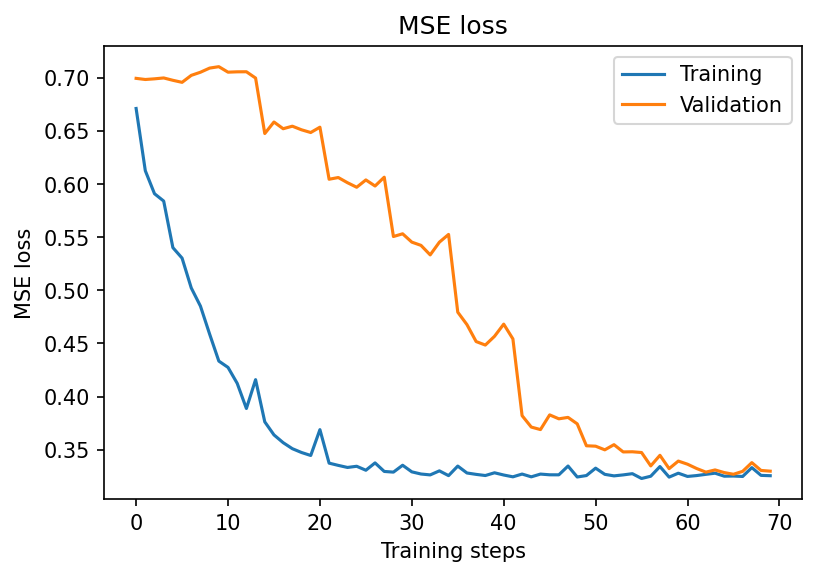

In [10]:
plt.figure(dpi=150)
plt.plot(losses, label="Training")
plt.plot(losses_valid, label="Validation")
plt.legend()
plt.title("MSE loss")
plt.xlabel("Training steps")
plt.ylabel("MSE loss")
plt.show()

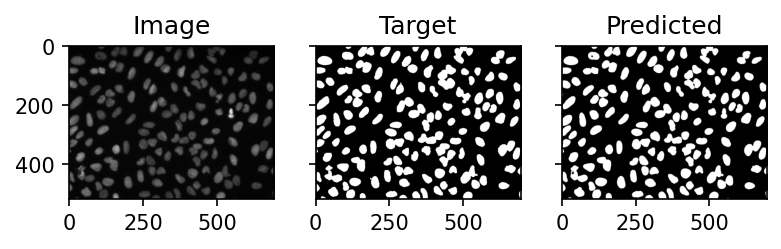

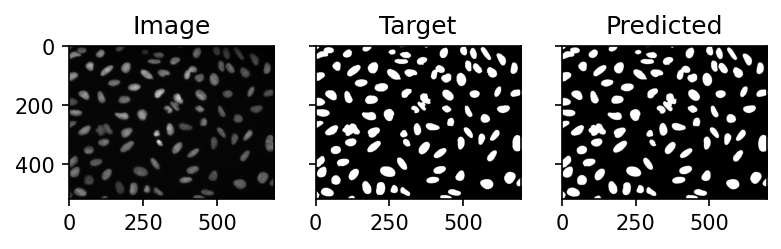

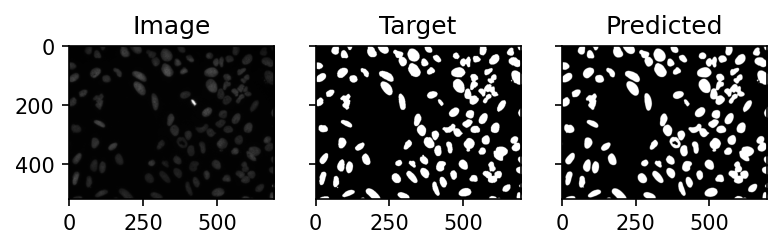

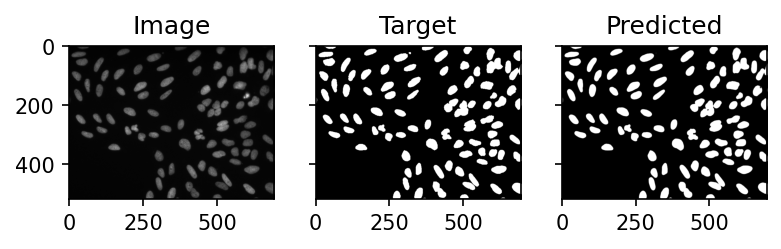

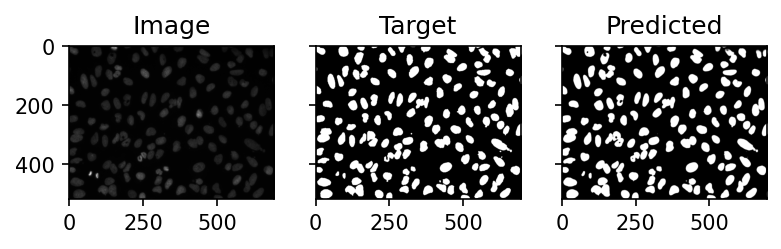

In [19]:
# evaluate on the test dataset
n = len(test_data)
unet_ious = np.empty(n)
unet_f1 = np.empty(n)
for idx, (image, mask) in enumerate(test_data):
    image = image.to("cuda:0").unsqueeze(0)
    with torch.no_grad():
        output = unet_model(image).to("cpu").numpy()

    if idx % 10 == 0:
        fig, axes = plt.subplots(1, 3, sharey=True, dpi=150)
        axes[0].imshow(image.cpu().squeeze(), cmap="gray")
        axes[0].set_title("Image")
        axes[1].imshow(mask.squeeze(), cmap="gray")
        axes[1].set_title("Target")
        axes[2].imshow(output[0, 1], cmap="gray")
        axes[2].set_title("Predicted")
        plt.show()
        
    unet_ious[idx] = mask_iou(output[0, 1] > 0.95, mask.numpy() > 0)
    unet_f1[idx] = mask_f1(output[0, 1] > 0.95, mask.numpy() > 0)

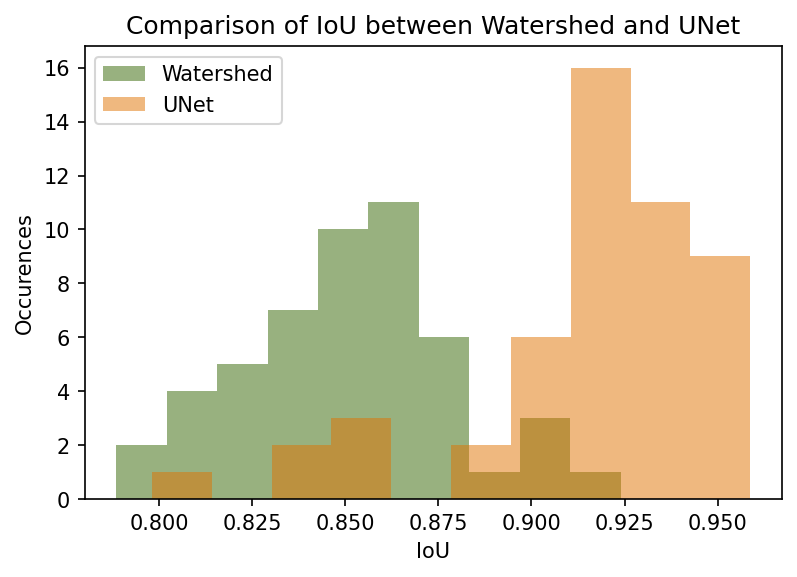

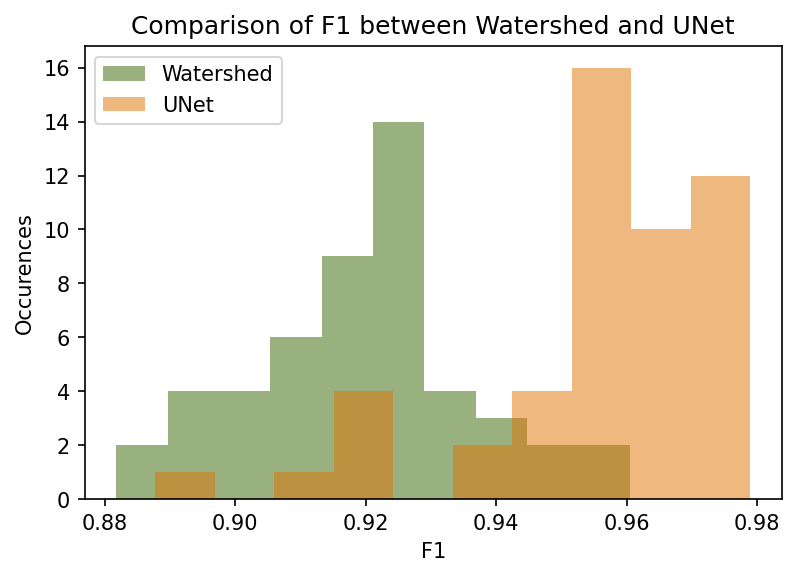

In [12]:
# compare watershed with unet
c1 = ( 50/255, 100/255, 0/255, 0.5)
c2 = (225/255, 115/255, 0/255, 0.5)

# look at IoU 
plt.figure(dpi=150)
plt.hist(watershed_ious, color=c1, label="Watershed")
plt.hist(unet_ious, color=c2, label="UNet")
plt.legend()
plt.title("Comparison of IoU between Watershed and UNet")
plt.xlabel("IoU")
plt.ylabel("Occurences")
plt.show()

# look at F1 
plt.figure(dpi=150)
plt.hist(watershed_f1, color=c1, label="Watershed")
plt.hist(unet_f1, color=c2, label="UNet")
plt.legend()
plt.title("Comparison of F1 between Watershed and UNet")
plt.xlabel("F1")
plt.ylabel("Occurences")
plt.show()

# Detection with [Contour Proposal Network](https://celldetection.org)

uint8 (520, 696, 3) (7, 124)


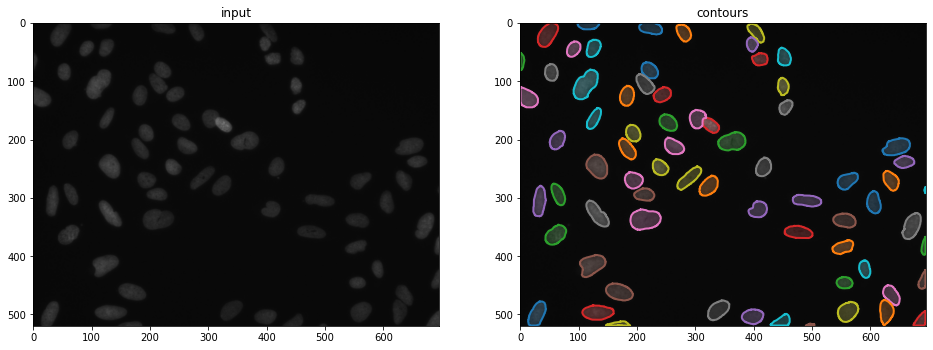

uint8 (520, 696, 3) (7, 138)


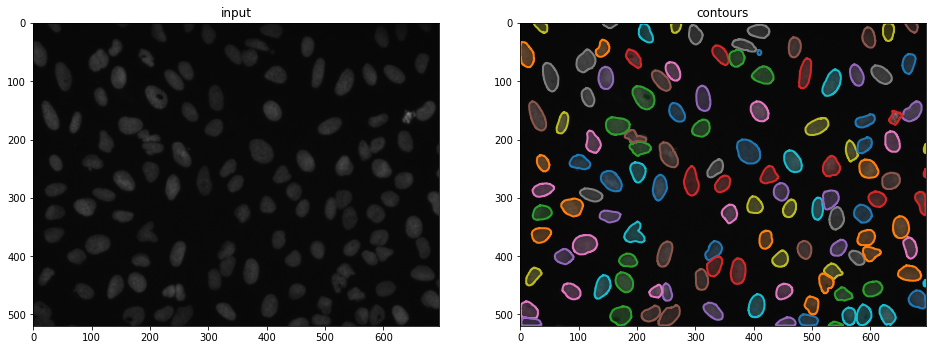

uint8 (520, 696, 3) (7, 212)


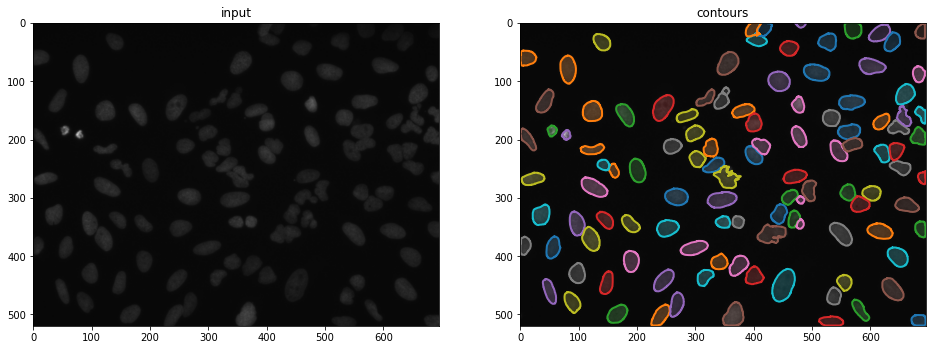

uint8 (520, 696, 3) (8, 155)


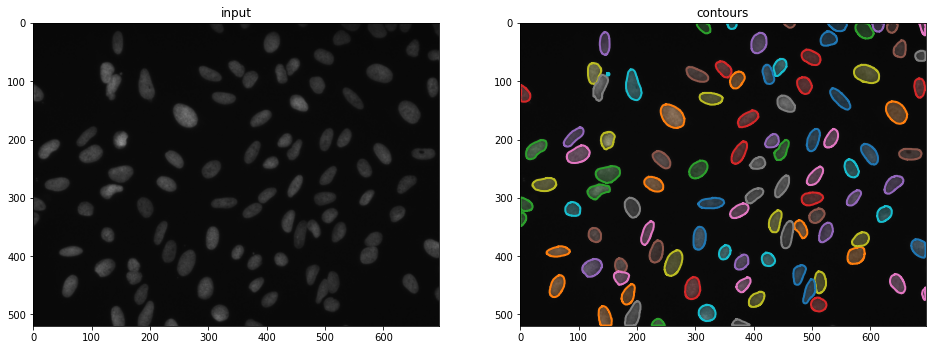

uint8 (520, 696, 3) (7, 95)


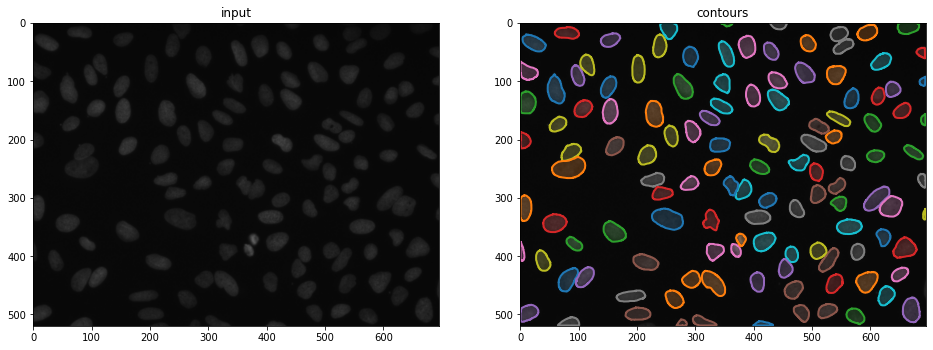

In [20]:
# Demo taken from www.celldetection.org
import torch, cv2, celldetection as cd
from matplotlib import pyplot as plt

# Load pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = "cpu"
model = cd.fetch_model('ginoro_CpnResNeXt101UNet-fbe875f1a3e5ce2c', check_hash=True).to(device)
model.eval()

for i in range(5):
    # Load input
    img = ((train_data.__getitem__(i, tensor=False)[0]) * 255).astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    print(img.dtype, img.shape, (img.min(), img.max()))

    # Run model
    with torch.no_grad():
        x = cd.to_tensor(img, transpose=True, device=device, dtype=torch.float32)
        x = x / 255  # ensure 0..1 range
        x = x[None]  # add batch dimension: Tensor[3, h, w] -> Tensor[1, 3, h, w]
        y = model(x)

    # Show results for each batch item
    contours = y['contours']
    for n in range(len(x)):
        cd.imshow_row(x[n], x[n], figsize=(16, 9), titles=('input', 'contours'))
        cd.plot_contours(contours[n])
        plt.show()